In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tensorflow import keras
from datetime import datetime, timedelta
from polygon import RESTClient

In [ ]:
# start = '20-01-01'
# end = '2025-05-14' #datetime.date.today().strftime('%Y-%m-%d')
# stock = 'AAPL'

# data = yf.download(stock, start, end)

client = RESTClient("qtp5Ybu7plDZOW7pZV_tKgeelkg3HCY8")

# Define date range
start_date = "2012-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

try:
    # Get daily bars for AAPL
    bars = client.get_aggs(
        ticker="AAPL",
        multiplier=1,
        timespan="day",
        from_=start_date,
        to=end_date
    )
    
    # Convert to DataFrame
    data = pd.DataFrame([bar.__dict__ for bar in bars])
    # Convert timestamp to datetime
    data['datetime'] = pd.to_datetime(data['timestamp'], unit='ms')
    data = data.set_index('datetime')

    
    
    print(data.head())
except Exception as e:
    print(f"Error with Polygon.io: {e}")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [12]:
import yfinance as yf
import time
import random
from requests.exceptions import RequestException

def download_with_retry(ticker, period="1y", interval="1d", max_retries=5, initial_delay=2):
    """
    Download stock data with exponential backoff retry logic.
    
    Args:
        ticker (str): Stock ticker symbol
        period (str): Time period to download (default: "1y")
        interval (str): Data interval (default: "1d")
        max_retries (int): Maximum number of retry attempts
        initial_delay (int): Initial delay in seconds between retries
        
    Returns:
        pandas.DataFrame: Downloaded stock data
    """
    attempt = 0
    delay = initial_delay
    
    while attempt < max_retries:
        try:
            print(f"Attempt {attempt+1}: Downloading {ticker}...")
            data = yf.download(ticker, period=period, interval=interval, progress=True)
            
            if data.empty:
                print(f"Warning: Empty data returned for {ticker}")
            
            return data
            
        except Exception as e:
            attempt += 1
            
            if "YFRateLimitError" in str(e) or "Too Many Requests" in str(e):
                jitter = random.uniform(0.8, 1.2)  # Add randomness to avoid thundering herd
                sleep_time = delay * jitter
                
                if attempt < max_retries:
                    print(f"Rate limit hit. Retrying in {sleep_time:.2f} seconds...")
                    time.sleep(sleep_time)
                    delay *= 2  # Exponential backoff
                else:
                    print(f"Maximum retries reached for {ticker}. Error: {e}")
                    raise
            else:
                print(f"Error downloading {ticker}: {e}")
                # For non-rate limit errors, we might want to retry fewer times
                if attempt < max_retries:
                    time.sleep(delay)
                else:
                    raise

# Example usage
try:
    # Single ticker
    aapl_data = download_with_retry("AAPL")
    print(aapl_data.tail())
    
    # Multiple tickers
    tickers = ["MSFT", "GOOG", "AMZN"]
    all_data = {}
    
    for ticker in tickers:
        # Add small delay between different tickers
        time.sleep(1)
        all_data[ticker] = download_with_retry(ticker)
        
except Exception as e:
    print(f"Failed to download data: {e}")

Attempt 1: Downloading AAPL...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Empty DataFrame
Columns: [(Adj Close, AAPL), (Close, AAPL), (High, AAPL), (Low, AAPL), (Open, AAPL), (Volume, AAPL)]
Index: []
Attempt 1: Downloading MSFT...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Attempt 1: Downloading GOOG...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Attempt 1: Downloading AMZN...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [4]:
data.reset_index(inplace=True)


In [5]:
data

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL


In [10]:
ma_100_days = data.close.rolling(100).mean()
ma_100_days

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
494    227.6733
495    227.1909
496    226.6757
497    226.1857
498    225.6914
Name: close, Length: 499, dtype: float64

AttributeError: 'DataFrame' object has no attribute 'Close'

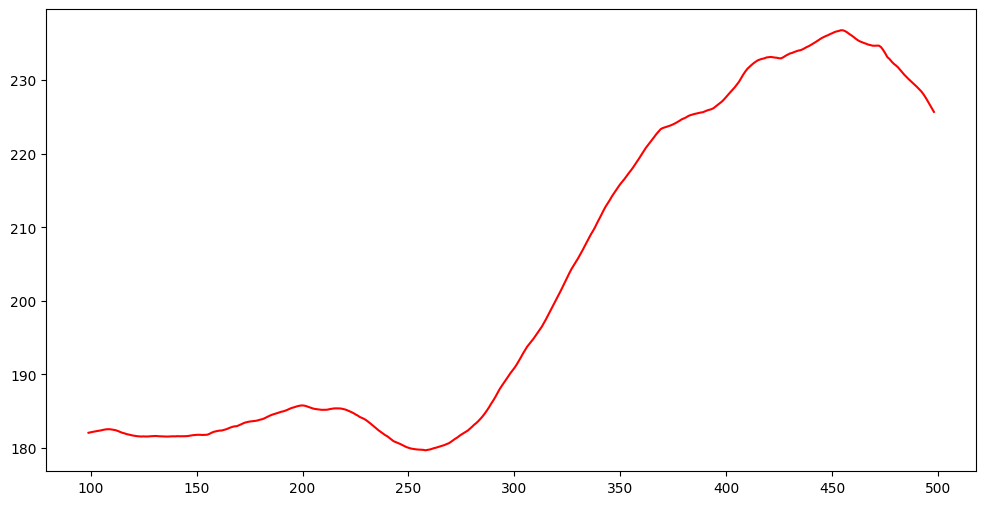

In [11]:
plt.figure(figsize=(12,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

In [12]:
ma_200_days = data.close.rolling(200).mean()
ma_200_days

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
494    226.93865
495    226.81030
496    226.67000
497    226.53765
498    226.40525
Name: close, Length: 499, dtype: float64

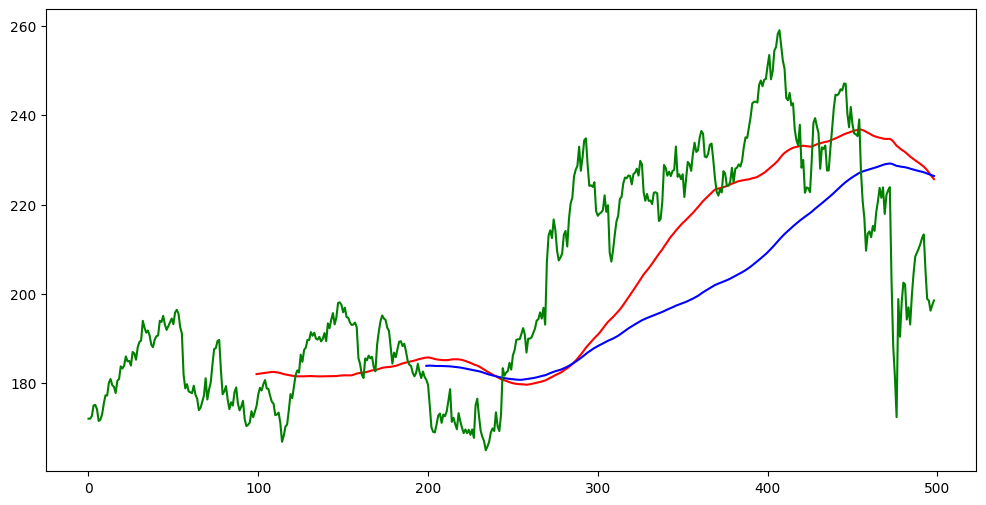

In [13]:
plt.figure(figsize=(12,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days,'b')
plt.plot(data.close,'g')
plt.show()

In [15]:
data_train = pd.DataFrame(data['close'][0: int(len(data)*0.80)])
data_test = pd.DataFrame(data['close'][int(len(data)*0.80): len(data)])

print(data_train.shape, data_test.shape)

(399, 1) (100, 1)


In [16]:
data_train.head()

,close
0,172.07
1,172.07
2,172.69
3,175.05
4,175.16


In [17]:
data_test.tail()

,close
494,198.89
495,198.51
496,196.25
497,197.49
498,198.53


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [19]:
data_train_scale = scaler.fit_transform(data_train)
data_train_scale

array([[0.08522179],
       [0.08522179],
       [0.09269527],
       [0.12114272],
       [0.12246866],
       [0.11089682],
       [0.07907425],
       [0.08244937],
       [0.09631148],
       [0.12572324],
       [0.14826422],
       [0.14766152],
       [0.18189489],
       [0.19226133],
       [0.17574735],
       [0.17128737],
       [0.1545323 ],
       [0.18768081],
       [0.19238187],
       [0.2264947 ],
       [0.22070878],
       [0.22842334],
       [0.25325458],
       [0.24011572],
       [0.24120058],
       [0.22854388],
       [0.26518804],
       [0.26133076],
       [0.24433462],
       [0.27796528],
       [0.29230955],
       [0.29640791],
       [0.34920444],
       [0.33100289],
       [0.31738187],
       [0.32316779],
       [0.30954677],
       [0.28459499],
       [0.27820636],
       [0.29857763],
       [0.30785921],
       [0.30966731],
       [0.34944552],
       [0.34631148],
       [0.36282546],
       [0.33907907],
       [0.32473481],
       [0.334

In [20]:
data_train_scale.shape

(399, 1)

In [21]:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])


In [22]:
x, y = np.array(x), np.array(y)

In [23]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [24]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

d:\Project OF BE\Stock_Model\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


model.summary()

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [27]:
model.fit(x,y, epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - loss: 0.2233
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0433
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0349
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 0.0299
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0261
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0225
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0203
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0200
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0212
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.0205
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0153
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - loss: 0.0153
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0177
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0210
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - lo

In [28]:
model.save('stock_prediction_model.h5')

In [29]:
pas_100_days = data_train.tail(100)

In [30]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)
data_test.head()

,close
0,218.54
1,217.49
2,217.96
3,218.24
4,218.80


In [31]:
data_test_scale  =  scaler.fit_transform(data_test)
data_test_scale.shape

(200, 1)

In [32]:
x_t = []
y_t = []

for i in range(100, data_test_scale.shape[0]):
    x_t.append(data_test_scale[i-100:i])
    y_t.append(data_test_scale[i,0])
x_t, y_t = np.array(x_t), np.array(y_t)
print(x_t.shape, y_t.shape)

(100, 100, 1) (100,)


In [33]:
y_predict = model.predict(x_t)
y_predict

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step


array([[0.74007714],
       [0.7488997 ],
       [0.75773203],
       [0.76660883],
       [0.77532476],
       [0.7837271 ],
       [0.79186195],
       [0.7998029 ],
       [0.8076935 ],
       [0.8156391 ],
       [0.8235352 ],
       [0.83110815],
       [0.8380495 ],
       [0.8439024 ],
       [0.84835005],
       [0.8513222 ],
       [0.8527989 ],
       [0.85289013],
       [0.85157734],
       [0.8488395 ],
       [0.84471893],
       [0.8395126 ],
       [0.8332384 ],
       [0.82601523],
       [0.81776047],
       [0.80847806],
       [0.79826254],
       [0.7872564 ],
       [0.77594924],
       [0.7651972 ],
       [0.7556996 ],
       [0.74783593],
       [0.7416905 ],
       [0.73689675],
       [0.7332023 ],
       [0.73037577],
       [0.7282505 ],
       [0.72649646],
       [0.7248371 ],
       [0.7232592 ],
       [0.7219631 ],
       [0.72129965],
       [0.7216336 ],
       [0.723166  ],
       [0.7259418 ],
       [0.72990143],
       [0.7348743 ],
       [0.740

In [34]:
y_t

array([0.87424942, 0.90785219, 0.93602771, 0.87332564, 0.89341801,
       0.94769053, 0.95669746, 0.99053118, 1.        , 0.96039261,
       0.92124711, 0.90069284, 0.82482679, 0.81916859, 0.83810624,
       0.80588915, 0.81154734, 0.74399538, 0.71570439, 0.70277136,
       0.75577367, 0.6448037 , 0.66466513, 0.57990762, 0.59364896,
       0.59168591, 0.58152425, 0.66327945, 0.76027714, 0.77297921,
       0.75254042, 0.73418014, 0.64191686, 0.69722864, 0.69341801,
       0.70207852, 0.63752887, 0.63775982, 0.69515012, 0.74422633,
       0.79803695, 0.8334873 , 0.83198614, 0.83660508, 0.84769053,
       0.84445727, 0.86235566, 0.86166282, 0.78452656, 0.74919169,
       0.80161663, 0.75762125, 0.73337182, 0.73117783, 0.72644342,
       0.76963048, 0.63579677, 0.5591224 , 0.51454965, 0.43025404,
       0.47424942, 0.48013857, 0.46501155, 0.49445727, 0.4812933 ,
       0.52944573, 0.55785219, 0.59272517, 0.56709007, 0.59387991,
       0.52517321, 0.57401848, 0.58625866, 0.5943418 , 0.35531

In [35]:
scaler.scale_

array([0.01154734])

In [36]:
scale_factor = 1/scaler.scale_

In [37]:
y_predict = y_predict*scale_factor

In [38]:
y_t = y_t * scale_factor

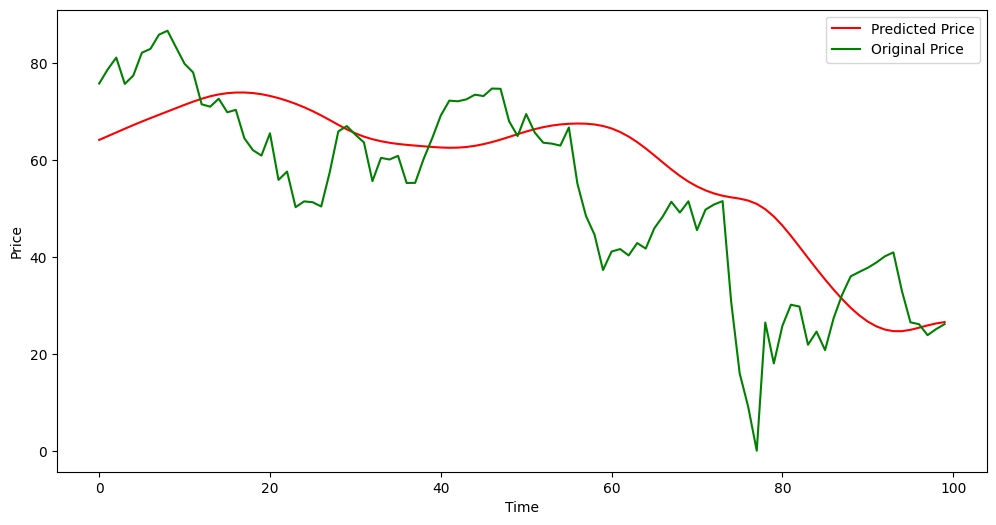

In [39]:
plt.figure(figsize=(12,6))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y_t, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [40]:
model.save('Stock Predictions Model.keras')